# Policy gradient method

In value based methods, we learn a value function $V(\mathbf{s})$ or a action value function $Q(\mathbf{s}, \mathbf{a})$, from which policies are derived. In contrast, policy-based methods directly parameterize and learn the policy $\pi_{\theta}$ without explicitly learning the value function. Formally, we want to find a policy that maximizes the expected return

$$\theta^* = \underset{\theta}{\text{argmax}} \; J(\theta)  =  \underset{\theta}{\text{argmax}} \; \mathbb{E}_{\tau \sim p_{\theta}(\tau)}\bigg[\underbrace{\sum_{t\geq 0}r(\mathbf{s}_t, \mathbf{a}_t)}_{r(\tau)}\bigg]$$

Where the trajectories $\tau = (\mathbf{s}_0, \mathbf{a}_0, r_0, \mathbf{s}_1,...)$ are sampled from the distribution induced by the policy $\pi_{\theta}$

$$p_{\theta}(\tau) = p(\mathbf{s}_0)\prod_{t\geq 0} \pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t) p(\mathbf{s}_{t+1}|\mathbf{s}_t, \mathbf{a}_t)$$

One potential way of optimizing the objective $J(\theta)$ is to estimate the expectation in a Monte-Carlo fashion. Specifically, we sample trajectories $\{\tau_i\}_{i\in [N]}$ and instead optimize

$$\theta^* = \underset{\theta}{\text{argmax}} \;  \frac{1}{N}\sum_{i=1}^N r(\tau_i)$$

However, there is a trouble in the optimization problem: we cannot differentiate through $\theta$ because it is part of a random variable! This means that we need to slightly reformulate the problem before applying Monte Carlo estimation. 

## Policy gradient theorem (Informal)

To address the issue mentioned earlier, we consider unrolling the expectation and, assuming regularity conditions, we interchange the gradient operator and the integral.

$$
\begin{align*}
    \nabla_{\theta} J(\theta) &= \nabla_{\theta} \mathbb{E}_{\tau \sim p_{\theta}(\tau)}[r(\tau)]\\
    &= \nabla_{\theta} \int r(\tau)p_{\theta}(\tau)d\tau\\
    &= \int r(\tau) \nabla_{\theta}p_{\theta}(\tau)d\tau\\
\end{align*}
$$

Next, we use the trick that

$$\nabla_{\theta} \log p_{\theta}(\tau) = \frac{\nabla_{\theta} p_{\theta}(\tau)}{p_{\theta}(\tau)}$$

Substituting gives us

$$
\begin{align*}
    \nabla_{\theta} J(\theta) &= \int r(\tau) \nabla_{\theta}p_{\theta}(\tau)d\tau\\
    &= \int r(\tau) \nabla_{\theta} \log p_{\theta}(\tau) p_{\theta}(\tau)d\tau\\
    &= \mathbb{E}_{\tau \sim p_{\theta}(\tau)} \bigg[r(\tau) \nabla_{\theta} \log p_{\theta}(\tau)\bigg]
\end{align*}
$$

This allows us to express the gradient of an expectation as the expectation of the gradient. We can further simplify the gradient by noting that

$$p_{\theta}(\tau) = p(\mathbf{s}_0)\prod_{t\geq 0} \pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t) p(\mathbf{s}_{t+1}|\mathbf{s}_t, \mathbf{a}_t) \implies \nabla_{\theta}\log p_{\theta}(\tau) = \sum_{t\geq 0} \nabla_{\theta} \pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)$$

Which gives us

$$\nabla_{\theta} J(\theta) =  \mathbb{E}_{\tau \sim p_{\theta}(\tau)} \bigg[\bigg(\sum_{t\geq 0}r(\mathbf{s}_t, \mathbf{a}_t)\bigg)\bigg(\sum_{t\geq 0}\nabla_{\theta} \log \pi_{\theta}(\mathbf{a}_t|\mathbf{s}_t)\bigg)\bigg] $$

The above statement is known as the policy gradient theorem, proposed by Sutton et al. in 1999. What's remarkable about it is that it allows us to approximate and compute the gradient of the objective!

$$\nabla_{\theta} J(\theta) \approx \frac{1}{K}\sum_{i=1}^K  \bigg(\sum_{t\geq 0}r(\mathbf{s}_{i,t}, \mathbf{a}_{i,t})\bigg)\bigg(\sum_{t\geq 0}\nabla_{\theta} \log \pi_{\theta}(\mathbf{a}_{i,t}|\mathbf{s}_{i,t})\bigg)$$

This motivates the REINFORCE algorithm, which essentially uses the policy gradient theorem as an update rule for the policy. The pseudocode for REINFORCE is presented below.

```{prf:algorithm} REINFORCE
:label: my-algorithm

**Inputs** Differentiable policy $\pi_{\theta}(\mathbf{a}|\mathbf{s})$, learning rate $\alpha$, number of episodes $N$, batch size $K$

1. While episode $n<N$:
	1. Generate $K$ trajectories following policy $\pi_{\theta}(\mathbf{a}|\mathbf{s})$
	2. Estimate $\nabla_{\theta} J(\theta) \approx \frac{1}{K}\sum_{i=1}^K  (\sum_{t\geq 0}r(\mathbf{s}_{i,t}, \mathbf{a}_{i,t}))(\sum_{t\geq 0}\nabla_{\theta} \log \pi_{\theta}(\mathbf{a}_{i,t}|\mathbf{s}_{i,t}))$
    3. Update $\theta\leftarrow \theta + \alpha \nabla_{\theta}J(\theta)$
```

## REINFORCE Implementation

We now implement the REINFORCE algorithm and test its performance on the CartPole environment. We begin by implementing the policy function $\pi_{\theta}$, which is parameterized as a one-layer neural network with a hidden dimension of $128$.

In [2]:
!pip -q install pybullet
!pip -q install stable-baselines3[extra]
!pip -q install pyvirtualdisplay
!apt-get install -y xvfb

import gym
import pybullet_envs
import matplotlib.pyplot as plt
import pyvirtualdisplay
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils as utils
from torch.utils.data import Dataset, DataLoader
from utils import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class Policy(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(Policy, self).__init__()
        self.net = SimpleNeuralNetwork(in_dim=state_dim, hidden_dim=hidden_dim, out_dim=action_dim, final_layer="Softmax")

    def forward(self, obs):
        return self.net(obs)

    def select_action(self, state):
        state = torch.tensor(state).float().to(DEVICE)
        action_dist = self.net(state)
        action_dist = torch.distributions.Categorical(probs=action_dist)
        action = action_dist.sample()
        action_log_prob = action_dist.log_prob(action)
        return action, action_log_prob

Next, we'll implement the REINFORCE algorithm in the `REINFORCEAgent` class, which inherits from the `Agent` class. The `Agent` class includes an `__init__` method, a `learn_episode` method, and a `learn` method. The `learn` method is pre-implemented and requires an `n_samples` input along with additional parameters specified by `*param`. It returns a dictionary containing keys `loss` and `reward`, which record the performance metrics of the learning process.

In [ ]:
class REINFORCEAgent(Agent):
    def __init__(self, env, policy, lr=1e-3, device="cpu"):
        self.env = env
        self.policy = policy.to(device)
        self.device = device
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=100, gamma=0.9)

    def learn_episode(self, *param):
        batch_size, max_steps, gamma = param
        self.optimizer.zero_grad()
        episode_loss, episode_reward = 0.0, 0.0
        for i in range(batch_size):
            log_probs, rewards, steps = 0, 0, 0
            state = self.env.reset()
            done = False
            while not done and steps < max_steps:
                action, log_prob = self.policy.select_action(state)
                next_state, reward, done, _ = self.env.step(int(action.item()))
                log_probs += log_prob
                rewards += reward * gamma ** steps
                state = next_state
                steps += 1
            episode_loss += -log_probs * reward / batch_size
            episode_reward += reward / batch_size
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()
        return loss.item(), episode_reward

We now test the performance of the `REINFORCEAgent` on the cartpole enviroment, varying the batch size. For the experiment, we tested batch size of $1, 8,$ and $32$. For each of the agents, we let them learn for $300$ episodes with decaying learning rate initialized at $10^{-3}$. 

In [ ]:
env = gym.make('CartPoleBulletEnv-v1')
policy = Policy(4, 2)
agent = REINFORCEAgent(env, policy, lr=1e-3, device=DEVICE)
history = agent.learn(n_episodes=300, batch_size=1, print_every=10)

We plot the results below. We see that increasing the batch size improves the performance of the model. THis can partly be the fact that we are using more data to train the model. However, note that using larger batch size also gives reward trajectories with smaller noise. One explanation is that the variance of the gradient estimator is smaller when using a larger batch size. Gradient variance is a problem for REINFORCE algorithm, in the next section we discuss methods of addressing this. 

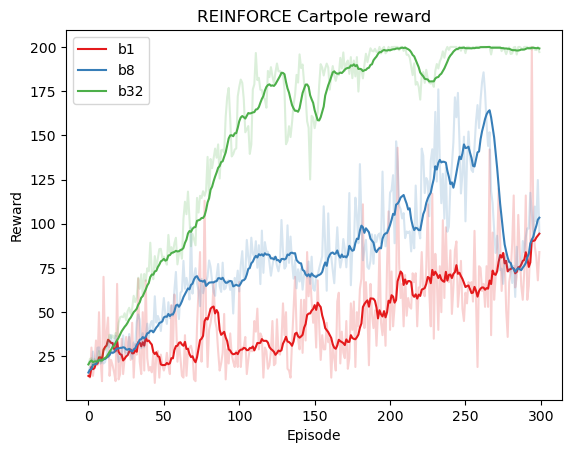

In [20]:
import numpy as np
import matplotlib.pyplot as plt

rewards = [np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/vanilla/b1_cartpole_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/vanilla/b8_cartpole_reward.npy"),
           np.load("/Users/raymondtsao/Desktop/ReinforcementLearningNotes/notes/PolicyGradient/vanilla/b32_cartpole_reward.npy")]

names = ["b1", "b8", "b32"]
colors = np.load("colors.npy")

def smooth(rewards, l):
    smoothed_rewards = []
    for i in range(len(rewards)):
        start_index = max(0, i - l + 1)
        smoothed_rewards.append(np.mean(rewards[start_index:i + 1]))
    return smoothed_rewards

for i, reward in enumerate(rewards):
    plt.plot(reward[:300], c=colors[i], alpha=0.2)
    plt.plot(smooth(reward[:300], 10), c=colors[i], label=names[i])
plt.title("REINFORCE Cartpole reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()